# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [4]:
rect_start = None
rect_end = None
drawing = False

In [5]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [6]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display

    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [6]:
coord = interactive_bbox_selection("test_image.jpg")

Coordinates: [142, 133, 3445, 5973]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


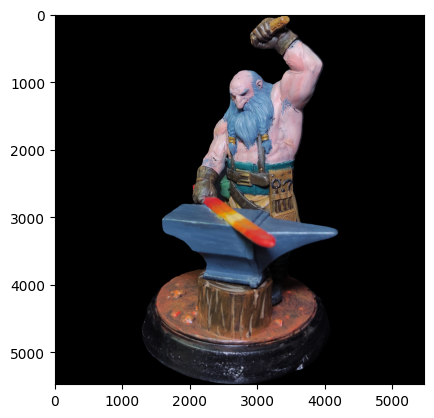

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [17]:
def segmenting_image(coordinates, model, conf = 0.4, iou = 0.4):
    results = model(source,
                    device="cpu",
                    retina_masks=True,
                    imgsz=640,
                    conf=conf,
                    iou=iou,
                    bboxes=coordinates)

    for result in results:
        img = np.copy(result.orig_img)

        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            isolated = img.copy()
            isolated[b_mask == 0] = 0

            contour = contour.reshape(-1, 2)

            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)

            # Crop the image to get only the segmented
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

            # Make the image square and centralize the segmented image
            height, width, _ = resultado_rgb.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 3), dtype=np.uint8)

            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2

            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

            cv2.imwrite("segmented.png", cv2.cvtColor(square_image, cv2.COLOR_RGB2BGR))
            plt.imshow(square_image)

### Combining everything

Coordinates: [180, 101, 948, 1627]

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0073.jpg: 640x640 1 0, 5248.1ms
Speed: 199.6ms preprocess, 5248.1ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


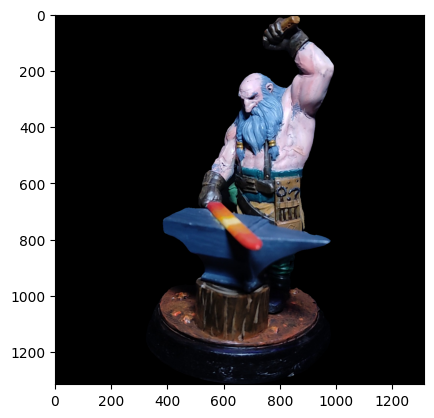

In [18]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.jpg"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, 0.2, 0.2)

## 3D reconstruction from videos

### Extract Frames from Video

In [1]:
import cv2
import os

def extract_frames(video_path, output_folder, resize_width=640, frame_interval=10):
    """Extracts frames from a video and resizes them."""
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame while maintaining aspect ratio
        height, width = frame.shape[:2]
        aspect_ratio = height / width
        new_height = int(resize_width * aspect_ratio)
        resized_frame = cv2.resize(frame, (resize_width, new_height))
        
        # Save frame
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.jpg")
            cv2.imwrite(frame_filename, resized_frame)
            extracted_count += 1
        
        frame_count += 1 

    cap.release()
    print(f"Extracted {frame_count} resized frames to {output_folder}")

# Example usage:
extract_frames("test_video.mp4", "frames")

Extracted 943 resized frames to frames


In [13]:
import cv2
import os

def extract_frames(video_path, output_folder, resize_width=640, frame_interval=10):
    """Extracts frames from a video and resizes them."""
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save frame
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1
        
        frame_count += 1 

    cap.release()
    print(f"Extracted {frame_count} resized frames to {output_folder}")

# Example usage:
extract_frames("test_video.mp4", "frames")

Extracted 943 resized frames to frames


### Run COLMAP

In [ ]:
import subprocess
import os

dir = os.getcwd()

# Define the relative path to your .bat file
bat_file_path = os.path.join(dir, "colmap/COLMAP.bat")

# Run the .bat file
result = subprocess.run([bat_file_path], shell=True)
if result.returncode != 0:
    print("No COLMAP installed, please follow this instructions: Bla bla bla (https://github.com/colmap/colmap/releases/tag/3.11.1)")

### Convert the Reconstruction to a 3D Model

In [ ]:
import open3d as o3d
import numpy as np

def visualize_point_cloud(ply_path):
    """Loads and visualizes the 3D point cloud using Open3D."""
    pcd = o3d.io.read_point_cloud(ply_path)
    o3d.visualization.draw_geometries([pcd])

# Visualize the reconstructed point cloud
visualize_point_cloud("colmap_output/dense/0/fused.ply")

## Pre-painting - coloring sketch

### Converting image to sketch

In [4]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

C:\Users\gusta\AppData\Local\Temp\ipykernel_8120\2039978225.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ss = imageio.imread(img)
C:\Users\gusta\AppData\Local\Temp\ipykernel_8120\2039978225.py:31: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)


True

### Creating a color pallete

In [5]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

Text(value='', description='Text:', placeholder='Type something')

ColorPicker(value='#ff0000', description='Pick a color')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click to submit text and color')

Button(description='Clear', icon='delete', style=ButtonStyle(), tooltip='Click to submit text and color')

Added: Soil with color #812304
Added: Peebles with color #7d5a40
Added: Mushroom head with color #e52a2a
Added: Mushroom Stem with color #e5b738
Added: Leaves with color #21b546
Added: Shoes with color #683308
Added: Pants with color #6470a0
Added: Rope with color #cd7b1d
Added: Jacket with color #e05a00
Added: Belt with color #552302
Added: Belt pocket with color #b46631
Added: Pans with color #878482
Added: Sleeping bag with color #045305
Added: Skin with color #8d4002
Added: Map with color #f7984a
Added: Square bag back with color #df915d
Added: Hood with color #2d511f
Added: Shield wood with color #804728
Added: Shield metal with color #74655d
Added: Horn metal with color #c99f2c
Added: Horn with color #9f7a50
Added: Hair with color #b19402
Added: Barrel  with color #5e331d
Added: Mug with color #89350b
Added: Mug and Barrel metal with color #949494
Added: Pick wood with color #a44b1e
Added: Barril  bag with color #a27701
Added: Bottles with color #5b92ec
Added: Pick metal with col

TraitError: The 'value' trait of a ColorPicker instance expected a valid HTML color, not the str ' #949494'.

Added: Bagpipe metal with color #6b5757
Added: Bagpipe with color #c53070
Added: Cilinder bag with color #4b865a
Added: Sword metal with color #7e8680
Added: Sword handle with color #ca6302
Added: Bird box with color #5693f5
Added: Bird body with color #5956f5
Added: Bird head with color #d21414
Added: Cage with color #6f4d4d


In [6]:
print(text_color_dict)

{'Soil': '#812304', 'Peebles': '#7d5a40', 'Mushroom head': '#e52a2a', 'Mushroom Stem': '#e5b738', 'Leaves': '#21b546', 'Shoes': '#683308', 'Pants': '#6470a0', 'Rope': '#cd7b1d', 'Jacket': '#e05a00', 'Belt': '#552302', 'Belt pocket': '#b46631', 'Pans': '#878482', 'Sleeping bag': '#045305', 'Skin': '#8d4002', 'Map': '#f7984a', 'Square bag back': '#df915d', 'Hood': '#2d511f', 'Shield wood': '#804728', 'Shield metal': '#74655d', 'Horn metal': '#c99f2c', 'Horn': '#9f7a50', 'Hair': '#b19402', 'Barrel ': '#5e331d', 'Mug': '#89350b', 'Mug and Barrel metal': '#949494', 'Pick wood': '#a44b1e', 'Barril  bag': '#a27701', 'Bottles': '#5b92ec', 'Pick metal': '#5d6674', 'Rope to wrap things': '#cc8e24', 'Bagpipe metal': '#6b5757', 'Bagpipe': '#c53070', 'Cilinder bag': '#4b865a', 'Sword metal': '#7e8680', 'Sword handle': '#ca6302', 'Bird box': '#5693f5', 'Bird body': '#5956f5', 'Bird head': '#d21414', 'Cage': '#6f4d4d'}


### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [9]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)